# Fine-Tuning the Text to Image Model

Let's teach our text to image generator what the new airplane looks like.

![Airplane](https://rhods-public.s3.amazonaws.com/sample-data/images/wright-flyer-small.jpg)

### Check GPU

**It's recommended that you shut down any other notebook kernels.**

This fine tuning process uses a lot of video memory.   Here, we'll check on how much we have available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

NVIDIA A10G, 23028 MiB, 22721 MiB


## Install Requirements

Here we install all the dependencies.  Most are for memory and [gpu optimizations](https://huggingface.co/docs/diffusers/training/dreambooth#optimizations-for-different-gpu-sizes), but to fine tune the model we'll need to install `diffusers` from git instead of just the package.

`xformers` is installed from whl so that it can work with the Torch version in this notebook image.

In [2]:
!pip install boto3 botocore
!pip install -q --upgrade accelerate transformers ftfy bitsandbytes
!pip install -q git+https://github.com/huggingface/diffusers


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!wget https://rhods-public.s3.amazonaws.com/src/xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl -O xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl
!pip install -q xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl

--2023-09-11 03:44:38--  https://rhods-public.s3.amazonaws.com/src/xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl
Resolving rhods-public.s3.amazonaws.com (rhods-public.s3.amazonaws.com)... 16.182.68.105, 54.231.162.145, 52.217.87.204, ...
Connecting to rhods-public.s3.amazonaws.com (rhods-public.s3.amazonaws.com)|16.182.68.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 127729734 (122M) [binary/octet-stream]
Saving to: ‘xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl’

xformers-0.0.21.dev 100%[===================>] 121.81M  63.1MB/s    in 1.9s    

2023-09-11 03:44:40 (63.1 MB/s) - ‘xformers-0.0.21.dev584-cp39-cp39-manylinux2014_x86_64.whl’ saved [127729734/127729734]


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [4]:
!pip list | grep -e torch -e torchvision -e diffusers -e accelerate -e torchvision -e transformers -e ftfy -e tensorboard -e Jinja2 -e xformers -e protobuf


accelerate                      0.22.0
diffusers                       0.21.0.dev0
ftfy                            6.1.1
Jinja2                          3.1.2
protobuf                        3.20.3
tensorboard                     2.11.2
tensorboard-data-server         0.6.1
tensorboard-plugin-wit          1.8.1
torch                           1.13.1
torchvision                     0.14.1
transformers                    4.33.1
xformers                        0.0.21.dev584

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


## Settings

Here we set up all the options for training.  Most are environment variables which will allow us to override values from pipelines and run this notebook with different setting such as the base model or number of training steps and learning rate.

In [5]:
import os
from datetime import datetime

date = datetime.now()
date_string = date.strftime("%Y%m%d%H%M%S")

VERSION = os.environ.get("VERSION", f"notebook-output")
MODEL_NAME = os.environ.get("MODEL_NAME", "stabilityai/stable-diffusion-2-1-base")
OUTPUT_DIR = os.path.join(os.getcwd(), f"{VERSION}/stable_diffusion_weights/wright-flyer")
DATA_DIR = os.path.join(os.getcwd(), f"{VERSION}/data")
INSTANCE_DATA_URL = os.environ.get("INSTANCE_DATA_URL", "https://rhods-public.s3.amazonaws.com/sample-data/images/wright-flyer.tar.gz")
INSTANCE_DIR = os.path.join(DATA_DIR, "instance_dir")
CLASS_DIR = os.path.join(DATA_DIR, "class_dir")
INSTANCE_PROMPT = os.environ.get("INSTANCE_PROMPT", "photo of an awrtflyr airplane")
CLASS_PROMPT = os.environ.get("CLASS_PROMPT", "a photo of an airplane")

NUM_CLASS_IMAGES = int(os.environ.get("NUM_CLASS_IMAGES", "200"))
MAX_TRAIN_STEPS = int(os.environ.get("MAX_TRAIN_STEPS", "800"))

GPU_ONNX_EXPORT = os.environ.get("GPU_ONNX_EXPORT", "TRUE")

ONNX_OUTPUT_DIR = os.path.join(os.getcwd(), f"{VERSION}/onnx-wright-flyer")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(INSTANCE_DIR, exist_ok=True)

print(f"Weights will be saved at {OUTPUT_DIR}")
print(f"It will be based on the model {MODEL_NAME}")
print(f"Training data located in downloaded from {INSTANCE_DATA_URL}")
print(f"We're going to train the difference between \"{INSTANCE_PROMPT}\" and \"{CLASS_PROMPT}\"")


Weights will be saved at /opt/app-root/src/shgriffi-demo/notebook-output/stable_diffusion_weights/wright-flyer
It will be based on the model stabilityai/stable-diffusion-2-1-base
Training data located in downloaded from https://rhods-public.s3.amazonaws.com/sample-data/images/redhat-dog.tar.gz
We're going to train the difference between "photo of an awrtflyr airplane" and "a photo of an airplane"


## Training

### Get Training Data


In [6]:
import sys
import os
import tarfile
import urllib

url = INSTANCE_DATA_URL
output = f"instance-images.tar.gz"
urllib.request.urlretrieve(url, output)

!tar -xzf instance-images.tar.gz -C $INSTANCE_DIR

### Set up the Training Job

In [7]:
!accelerate config default

Configuration already exists at /opt/app-root/src/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [8]:
!wget -O train_dreambooth.py https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py

--2023-09-11 03:44:46--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56184 (55K) [text/plain]
Saving to: ‘train_dreambooth.py’

train_dreambooth.py 100%[===================>]  54.87K  --.-KB/s    in 0.001s  

2023-09-11 03:44:46 (55.6 MB/s) - ‘train_dreambooth.py’ saved [56184/56184]


### Start Training

Here we kick off the training job with our chosen settings.  This will take about 15 minutes depending on settings and hardware.

In [9]:
!echo "MODEL_NAME=$MODEL_NAME"
!echo "OUTPUT_DIR=$OUTPUT_DIR"
!echo "DATA_DIR=$DATA_DIR"
!echo "INSTANCE_DIR=$INSTANCE_DIR"
!echo "CLASS_DATA_URL=$CLASS_DATA_URL"
!echo "CLASS_DIR=$CLASS_DIR"
!echo "INSTANCE_PROMPT=$INSTANCE_PROMPT"
!echo "CLASS_PROMPT=$CLASS_PROMPT"
!echo "NUM_CLASS_IMAGES=$NUM_CLASS_IMAGES"
!echo "MAX_TRAIN_STEPS=$MAX_TRAIN_STEPS"

MODEL_NAME=stabilityai/stable-diffusion-2-1-base
OUTPUT_DIR=/opt/app-root/src/shgriffi-demo/notebook-output/stable_diffusion_weights/wright-flyer
DATA_DIR=/opt/app-root/src/shgriffi-demo/notebook-output/data
INSTANCE_DIR=/opt/app-root/src/shgriffi-demo/notebook-output/data/instance_dir
CLASS_DATA_URL=
CLASS_DIR=/opt/app-root/src/shgriffi-demo/notebook-output/data/class_dir
INSTANCE_PROMPT=photo of an awrtflyr airplane
CLASS_PROMPT=a photo of an airplane
NUM_CLASS_IMAGES=200
MAX_TRAIN_STEPS=800


In [14]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="$INSTANCE_PROMPT" \
  --class_prompt="$CLASS_PROMPT" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 --gradient_checkpointing \
  --use_8bit_adam \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=$NUM_CLASS_IMAGES \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --enable_xformers_memory_efficient_attention

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
09/11/2023 03:57:07 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: no

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'timestep_spacing', 'clip_sample_range', 'variance_type', 'thresholding', 'sample_max_value', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'conv_out_kernel', 'mid_block_only_cross_attention', 'resnet_out_scale_factor', 'time_embedding_act_fn', 'addition_embed_type', 'upcast_attention', 'time_cond_proj_dim', 'encoder_hid_dim', 'addition_embed_type_num_heads', 'cross_attention_norm', 'dropout', 

### Examine the output

If everything went well, we should have generated model weights in the `$OUTPUT_DIR` including those for the tokenizer, vae, unet, and text encoder.  You could now load these weights and generate images with our finetuned model.  You could simply replace any references to our Huggingface model (`runwayml/stable-diffusion-v1-5`) with the path to our new weights (e.g. `./notebook-output/stable_diffusion_weights/redhat-dog`)

It's also ready for upload to Huggingface, such as [cfchase/stable-diffusion-wright-flyer](https://huggingface.co/cfchase/stable-diffusion-wright-flyer), where you can use those weights in another notebook or application.  To try out the custom weight from huggingface (or any other weights) with multiple images generated, try the notebook [misc-notebooks/generate_multiple.ipynb](misc-notebooks/generate_multiple.ipynb).

In [15]:
!ls $OUTPUT_DIR

checkpoint-500	   logs		     scheduler	   tokenizer  vae
feature_extractor  model_index.json  text_encoder  unet


# Export to ONNX

In order to to serve the model as an API, we need to use a format the model server understands.  The [Open Neural Network Exchange (ONNX)](https://onnx.ai/) is an open format built to represent machine learning models that enables AI developers to use models with a variety of frameworks, tools, runtimes, and compilers.  Next we'll convert the model to ONNX using the process the Huggingface diffusers library recommends in its [documentation](https://huggingface.co/docs/diffusers/v0.20.0/en/optimization/onnx).


### Install Dependencies

A new key dependency will be the [optimum](https://github.com/huggingface/optimum) library.

In [23]:
import torch

if GPU_ONNX_EXPORT.upper == "TRUE" and torch.cuda.is_available():
    !pip install -q optimum["onnxruntime-gpu"]
else:
    !pip install -q optimum["onnxruntime"]


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


By loading the model into an `ORTStableDiffusionPipeline` and `save_pretrained`, we will end up with 4 separate ONNX models, `text_encoder`, `unet`, `vae_decoder`, and `vae_encoder`.

Also, let's see what a generated image of `awrtflyr` looks like.  Before, the model had no idea, but now, it should generate a picture of our specific airplane.

Framework not specified. Using pt to export to ONNX.
Keyword arguments {'subfolder': '', 'trust_remote_code': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Using framework PyTorch: 1.13.1+cu117
Using framework PyTorch: 1.13.1+cu117
Saving external data to one file...
Using framework PyTorch: 1.13.1+cu117
Using framework PyTorch: 1.13.1+cu117


  0%|          | 0/51 [00:00<?, ?it/s]

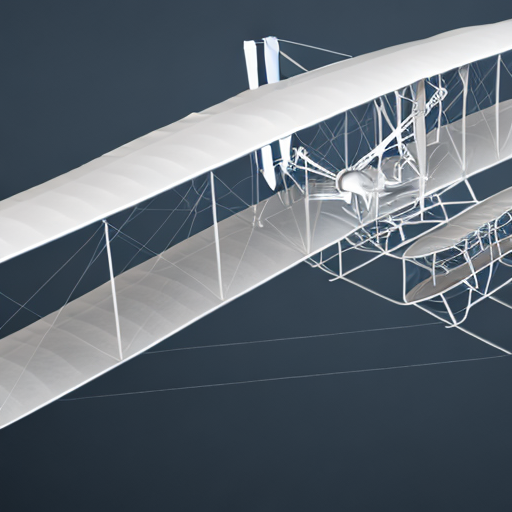

In [24]:
from optimum.onnxruntime import ORTStableDiffusionPipeline
import torch

model_id = OUTPUT_DIR
pipeline = ORTStableDiffusionPipeline.from_pretrained(model_id, export=True)

device = torch.device("cuda" if GPU_ONNX_EXPORT.upper == "TRUE" and torch.cuda.is_available() else "cpu")
pipeline.to(device)
prompt = "photo of an awrtflyr airplane"
image = pipeline(prompt).images[0]
pipeline.save_pretrained(ONNX_OUTPUT_DIR)
image

### Cleanup

Before moving on, we'll free up as much video memory as possible

In [25]:
import gc
import torch


try:
    del image
except NameError:
    print("image already deleted")
    
try:
    del pipeline
except NameError:
    print("pipeline already deleted")
try:
    del device
except NameError:
    print("device already deleted")
    
gc.collect()
torch.cuda.empty_cache()

## Save to S3

Now we have our model in a portable ONNX format, however, it's not doing much good in this notebook.  We need to push the model to our connected storage location.  Then we can use it in another notebook or serve the models for use within an application.

Note:  This requires a data connection to an S3 compatible bucket.  As part of the setup for this project, you added the [setup-s3.yaml](https://github.com/cfchase/text-to-image-demo/blob/main/setup/setup-s3.yaml) which created a local s3 bucket and data connections.

In [26]:
import os
import boto3
import botocore

aws_access_key_id = os.environ.get('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.environ.get('AWS_SECRET_ACCESS_KEY')
endpoint_url = os.environ.get('AWS_S3_ENDPOINT')
region_name = os.environ.get('AWS_DEFAULT_REGION')
bucket_name = os.environ.get('AWS_S3_BUCKET')

session = boto3.session.Session(aws_access_key_id=aws_access_key_id,
                                aws_secret_access_key=aws_secret_access_key)

s3_resource = session.resource(
    's3',
    config=botocore.client.Config(signature_version='s3v4'),
    endpoint_url=endpoint_url,
    region_name=region_name)

bucket = s3_resource.Bucket(bucket_name)


def upload_directory_to_s3(local_directory, s3_prefix):
    for root, dirs, files in os.walk(local_directory):
        for filename in files:
            file_path = os.path.join(root, filename)
            relative_path = os.path.relpath(file_path, local_directory)
            s3_key = os.path.join(s3_prefix, relative_path)
            print(f"{file_path} -> {s3_key}")
            bucket.upload_file(file_path, s3_key)


def list_objects(prefix):
    filter = bucket.objects.filter(Prefix=prefix)
    for obj in filter.all():
        print(obj.key)


In [27]:
upload_directory_to_s3(ONNX_OUTPUT_DIR, f"text-to-image/{VERSION}/onnx-wright-flyer")

/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/model_index.json -> text-to-image/notebook-output/onnx-wright-flyer/model_index.json
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/text_encoder/model.onnx -> text-to-image/notebook-output/onnx-wright-flyer/text_encoder/model.onnx
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/text_encoder/config.json -> text-to-image/notebook-output/onnx-wright-flyer/text_encoder/config.json
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/unet/model.onnx -> text-to-image/notebook-output/onnx-wright-flyer/unet/model.onnx
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/unet/config.json -> text-to-image/notebook-output/onnx-wright-flyer/unet/config.json
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wright-flyer/unet/model.onnx_data -> text-to-image/notebook-output/onnx-wright-flyer/unet/model.onnx_data
/opt/app-root/src/shgriffi-demo/notebook-output/onnx-wrigh

In [28]:
list_objects(f"text-to-image/{VERSION}/onnx-wright-flyer")

text-to-image/notebook-output/onnx-wright-flyer/feature_extractor/preprocessor_config.json
text-to-image/notebook-output/onnx-wright-flyer/model_index.json
text-to-image/notebook-output/onnx-wright-flyer/scheduler/scheduler_config.json
text-to-image/notebook-output/onnx-wright-flyer/text_encoder/config.json
text-to-image/notebook-output/onnx-wright-flyer/text_encoder/model.onnx
text-to-image/notebook-output/onnx-wright-flyer/tokenizer/merges.txt
text-to-image/notebook-output/onnx-wright-flyer/tokenizer/special_tokens_map.json
text-to-image/notebook-output/onnx-wright-flyer/tokenizer/tokenizer_config.json
text-to-image/notebook-output/onnx-wright-flyer/tokenizer/vocab.json
text-to-image/notebook-output/onnx-wright-flyer/unet/config.json
text-to-image/notebook-output/onnx-wright-flyer/unet/model.onnx
text-to-image/notebook-output/onnx-wright-flyer/unet/model.onnx_data
text-to-image/notebook-output/onnx-wright-flyer/vae_decoder/config.json
text-to-image/notebook-output/onnx-wright-flyer/v

### Remember the S3 Prefixes 

Take note of these s3 keys and prefixes.  We'll need to refer to them later when serving our model.  You'll need to provide the prefix up to each onnx file to download the onnx file and any adjacent files necessary.

For example, `path_to/unet/model.onnx` also requires `path_to/unet/model.onnx_data`, so we would use `path_to/unet` for serving.  By default, we'd use 4 paths for the 4 models:
```
text-to-image/notebook-output/onnx-wright-flyer/text_encoder
text-to-image/notebook-output/onnx-wright-flyer/unet
text-to-image/notebook-output/onnx-wright-flyer/vae_encoder
text-to-image/notebook-output/onnx-wright-flyer/vae_encoder

```

### Next

You can explore pipelines [3 Finetune Text to Image](3_Finetune_Text_to_Image.pipeline)

The next notebook [Notebook 4 - Remote Inference](4_remote_inference.ipynb), tests out Red Hat OpenShift Data Science Serving capabilities.  Before trying it out, you must have deployed a custom runtime for Triton, created a model server, and deployed the 4 models.

If you're interested in skipping the manual steps, you can go this project in the OpenShift console and import [serving/models.yaml](serving/models.yaml)